# Tasks
The objective of this notebook is to use machine learning model to provide a ward national landcover in 2021. 

In [33]:
# import libraries
import os
import ee
import geemap

In [34]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AX4XfWiTEMiE-CmhA3j2AMKnkWdBVIEO0ntaFeI12Gxy1HgdIHjC6BQZifY

Successfully saved authorization token.


In [3]:
!pwd

/Users/noe/Documents/PostDoc/Workshop/Day 3


## Select the ward of interest and load it raster

In [35]:
Map = geemap.Map(center=(-33.918861, 18.423300))
# Upload the shapefile of the ROI(SA)
w    = geemap.shp_to_ee('/Users/noe/Documents/PostDoc/Workshop/Day 3/SA4/ADM4_PCODE_ZA5950089.shp')
Map.addLayer(w, {}, 'ward_of_interest')
Map

Map(center=[-33.918861, 18.4233], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [36]:
def maskS2clouds(image):
    qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus(shadow), respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).bitwiseAnd(cirrusBitMask).eq(0)
    return image.updateMask(mask).divide(10000)

s2 = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2020-01-01', '2020-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)).map(maskS2clouds)
# ///////////////// Use Median Band in parameters///////////////////////

rgbVis  = {
  'min': 0.0,
  'max': 0.3,
  'gamma':1.4,
  'bands': ['B4_median', 'B3_median', 'B2_median'],
}

median = s2.reduce(ee.Reducer.median())

# ////////////////Mosaic these two image collections///////////////////

mosaic_1 = ee.ImageCollection.fromImages([median]).mosaic()

# ////////////////////////Clip by assets or roi////////////////////////

sentinel_2_2020= mosaic_1.clip(w)

# /////////////// Display the clipped ImageCollection/////////////////

Map.addLayer(sentinel_2_2020, rgbVis, 'sentinel_roi_2020')
Map

Map(bottom=616224.0, center=[-29.989434054144674, 30.91415242172449], controls=(WidgetControl(options=['positi…

In [37]:
def maskS2clouds(image):
    qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).bitwiseAnd(cirrusBitMask).eq(0)
    return image.updateMask(mask).divide(10000)

s2 = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2021-01-01', '2021-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)).map(maskS2clouds)
# ///////////////// Use Median Band in parameters///////////////////////

median = s2.reduce(ee.Reducer.median())

# ////////////////Mosaic these two image collections///////////////////

mosaic_1 = ee.ImageCollection.fromImages([median]).mosaic()

# ////////////////////////Clip by assets or roi////////////////////////

sentinel_2_2021 = mosaic_1.clip(w)

# /////////////// Display the clipped ImageCollection/////////////////

Map.addLayer(sentinel_2_2021, rgbVis, 'sentinel_roi_2021')
Map

Map(bottom=2463992.0, center=[-29.989136695821674, 30.907545089721683], controls=(WidgetControl(options=['posi…

# Collecting the training data

In [38]:
# Load the SANLC 20202 for the roi
sanlcd2020 = ee.Image('users/noecareme/SA_NLC_2020_GEO').select('b1').clip(w)

In [39]:
# Generate the training dataset.

points = sanlcd2020.sample(**{
    'region': w,
    'scale': 20,
    'numPixels': 1500,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map.addLayer(points, {}, 'training', False)
Map

Map(bottom=2463992.0, center=[-29.989136695821674, 30.907545089721683], controls=(WidgetControl(options=['posi…

In [49]:
# Select the bands to use for classification.

bands = ['B1_median', 'B2_median', 'B3_median', 'B4_median', 'B5_median', 'B6_median', 'B7_median','B8_median','B8A_median','B9_median','B11_median','B12_median']

# This property of the table stores the land cover labels.
label = 'b1'

# Overlay the 1500 points from the SANLC2020 on the sentinel_2_2020 imagery.

sample = sentinel_2_2020.select(bands).sampleRegions(**{
  'collection': points,
  'properties': [label],
  'scale': 20
})

# Adds a column of deterministic pseudorandom numbers. 

sample = sample.randomColumn()

# Set the split parameter

split = 0.7
# Define the training and validation sets
training = sample.filter(ee.Filter.lt('random', split))
validation = sample.filter(ee.Filter.gte('random', split))

## Train the classifier

In [67]:
classifier = ee.Classifier.smileRandomForest(10).train(training, label, bands)

### Classify the image and display the results

In [68]:
# Classify the image with the same bands used for training.
result = sentinel_2_2020.select(bands).classify(classifier)

dico = {"names": ["Contiguous (indigenous) Forest (combined very high, high, medium)", "Contiguous Low Forest & Thicket (combined classes)", "Dense Forest & Woodland (35 - 75% cc)", "Open Woodland (10 - 35% cc)", "Contiguous & Dense Planted Forest (combined classes)", "Open & Sparse Planted Forest", "Temporary Unplanted Forest", "Low Shrubland (other regions)", "Low Shrubland (Fynbos)", "Low Shrubland (Succulent Karoo)", "Low Shrubland (Nama Karoo)", "Sparsely Wooded Grassland (5 - 10% cc)", "Natural Grassland", "Natural Rivers", "Natural Estuaries & Lagoons", "Natural Ocean, Coastal", "Natural Lakes", "Natural Pans (flooded @ obsv time)", "Artificial Dams (incl. canals)", "Artificial Sewage Ponds", "Artificial Flooded Mine Pits", "Herbaceous Wetlands (currently mapped)", "Herbaceous Wetlands (previous mapped extent)", "Mangrove Wetlands", "Natural Rock Surfaces", "Dry Pans", "Eroded Lands", "Sand Dunes (terrestrial)", "Coastal Sand Dunes & Beach Sand", "Bare Riverbed Material", "Other Bare", "Cultivated Commercial Permanent Orchards", "Cultivated Commercial Permanent Vines", "Cultivated Commercial Sugarcane Pivot Irrigated", "Commercial Permanent Pineapples", "Cultivated Commercial Sugarcane Non-Pivot (all other)", "Cultivated Emerging Farmer Sugarcane Non-Pivot (all other)", "Commercial Annuals Pivot Irrigated", "Commercial Annuals Non-Pivot Irrigated", "Commercial Annuals Crops Rain-Fed / Dryland / Non-Irrigated", "Subsistence / Small-Scale Annual Crops", "Fallow Land & Old Fields (Trees)", "Fallow Land & Old Fields (Bush)", "Fallow Land & Old Fields (Grass)", "Fallow Land & Old Fields (Bare)", "Fallow Land & Old Fields (Low Shrub)", "Residential Formal (Tree)", "Residential Formal (Bush)", "Residential Formal (low veg / grass)", "Residential Formal (Bare)", "Residential Informal (Tree)", "Residential Informal (Bush)", "Residential Informal (low veg / grass)", "Residential Informal (Bare)", "Village Scattered (bare only)", "Village Dense (bare only)", "Smallholdings (Tree)", "Smallholdings (Bush)", "Smallholdings (low veg / grass)", "Smallholdings (Bare)", "Urban Recreational Fields (Tree)", "Urban Recreational Fields (Bush)", "Urban Recreational Fields (Grass)", "Urban Recreational Fields (Bare)", "Commercial", "Industrial", "Roads & Rail (Major Linear)", "Mines: Surface Infrastructure", "Mines: Extraction Sites: Open Cast & Quarries combined", "Mines: Extraction Sites: Salt Mines", "Mines: Waste (Tailings) & Resource Dumps", "Land-fills", "Fallow Land & Old Fields (wetlands)"], "colors": ["#F2F2F2", "#065106", "#005F00", "#008500", "#F74006", "#F9764D", "#F9906C", "#B8ABD1", "#8FAB39", "#AC92C5", "#AC9CDA", "#85D285", "#D2B485", "#00009F", "#041FA7", "#0639AB", "#0D50AC", "#125FAC", "#1373B4", "#1D81B6", "#1F8EB8", "#06DEDC", "#06E0D0", "#9F1FEC", "#ffffe0", "#DCDAC5", "#F9E0E0", "#F9F9C5", "#F9F9A7", "#CDD2E0", "#ffffe0", "#A62C39", "#B31F5C", "#DB0000", "#9F3978", "#FF0000", "#F64D6C", "#381A12", "#521F1C", "#85402C", "#C5735F", "#C1436C", "#C55E82", "#D27592", "#E0AAB8", "#DB90A9", "#ECDB0F", "#F6EC13", "#F9F81F", "#FFFF29", "#EC82EC", "#F691E0", "#F99FCF", "#FFC5CF", "#ECC500", "#FFD91F", "#AC7879", "#B89192", "#C49C9E", "#D2B8B8", "#BFFF00", "#33FF33", "#66FF66", "#99FF99", "#C49F0D", "#8F8506", "#F9DD03", "#FFFF00", "#B30606", "#C50606", "#D21D1A", "#F95479", "#6CE7DC"]}

# # Display the clusters with random colors.
Map.addLayer(result, {'min':1, 'max':73,'palette':dico['colors']}, 'sentinel_classified_2020') #result.randomVisualizer()
Map

Map(bottom=9856185.0, center=[-30.009893884207866, 30.88767528533936], controls=(WidgetControl(options=['posit…

### Accuracy Assessment

In [69]:
train_accuracy = classifier.confusionMatrix()

In [70]:
train_accuracy.getInfo()

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  9,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  106,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [71]:
import pandas as pd
D = pd.DataFrame(train_accuracy.getInfo())
D.head(30)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,9,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,106,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# RandomForest()
train_accuracy.accuracy().getInfo()

0.9277673545966229

In [73]:
# RandomForest
train_accuracy.kappa().getInfo()

0.9120236741439719

In [74]:
# RandomForest
PA = pd.DataFrame(train_accuracy.producersAccuracy().getInfo())
PA.head()

,0
0,0.000000
1,0.818182
2,0.990654
3,0.888889
4,0.000000


In [75]:
# RandomForest
CA = pd.DataFrame(train_accuracy.consumersAccuracy().getInfo())
CA.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0,1,0.929825,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0.956522


#### Validation dataset

In [76]:
# RandomForest
validated = validation.classify(classifier)

In [77]:
# RandomForest
validation_accuracy = validated.errorMatrix('b1', 'classification')

In [78]:
# RandomForest
VA = pd.DataFrame(validation_accuracy.getInfo())
VA.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,2,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# RandomForest
validation_accuracy.accuracy().getInfo()

0.43115124153498874

In [80]:
# RandomForest
validation_accuracy.kappa().getInfo()

0.28857563456305485

In [81]:
# RandomForest
VPA = validation_accuracy.producersAccuracy().getInfo()
pd.DataFrame(VPA).head()

,0
0,0.000000
1,0.000000
2,0.641026
3,0.000000
4,0.000000


In [82]:
# RandomForest
VCA = pd.DataFrame(validation_accuracy.consumersAccuracy().getInfo())
pd.DataFrame(VCA).head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0,0,0.409836,0,0,0,0,0,0,0,...,0,0.333333,0.666667,0,0,0,0,0,0,0.428571


### Test the model on SANLC 2018

In [83]:
def maskS2clouds(image):
    qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).bitwiseAnd(cirrusBitMask).eq(0)
    return image.updateMask(mask).divide(10000)

s2 = ee.ImageCollection('COPERNICUS/S2_SR').filterDate('2018-01-01', '2018-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)).map(maskS2clouds)
# ///////////////// Use Median Band in parameters///////////////////////

median = s2.reduce(ee.Reducer.median())

# ////////////////Mosaic these two image collections///////////////////

mosaic_1 = ee.ImageCollection.fromImages([median]).mosaic()

# ////////////////////////Clip by assets or roi////////////////////////

sentinel_2_2018 = mosaic_1.clip(w)

# /////////////// Display the clipped ImageCollection/////////////////

#Map.addLayer(sentinel_2_2018, rgbVis, 'sentinel_roi_2018')
#Map

In [84]:
sanlcd2018 = ee.Image('projects/sat-io/open-datasets/landcover/SA_NLC_2018').select('b1').clip(w)

# Make the training dataset.
points1 = sanlcd2018.sample(**{
    'region': w,
    'scale': 20,
    'numPixels': 400,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

In [85]:
### Split the 1000 points into training and testing
# Use these bands for prediction.
bands = ['B1_median', 'B2_median', 'B3_median', 'B4_median', 'B5_median', 'B6_median', 'B7_median','B8_median','B8A_median','B9_median','B11_median','B12_median']

# This property of the table stores the land cover labels.
label = 'b1'

# Overlay the points on the imagery to get training.
sample1 = sentinel_2_2018.select(bands).sampleRegions(**{
  'collection': points1,
  'properties': [label],
  'scale': 20
})

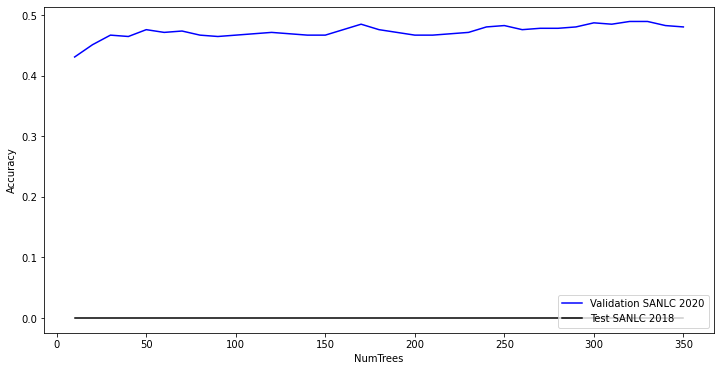

In [86]:
#####/Classify the test FeatureCollection.#####*

validation_2020 = validation.classify(classifier)

# Tune the numberOfTrees parameter.
numTreesList = ee.List.sequence(10, 350, 10)

############ Functions to loop through the number of trees ##########/

def accuracies_2020(numTrees):
    classifier_2020 = ee.Classifier.smileRandomForest(numTrees).train(training, label, bands)
    # Here we are classifying a table instead of an image
    # Classifiers work on both images and tables
    return validation.classify(classifier_2020).errorMatrix(label, 'classification').accuracy(),sample1.classify(classifier_2020).errorMatrix(label, 'classification').accuracy()

T = [accuracies_2020(numTrees) for numTrees in numTreesList.getInfo()]
t = []
for i in range(len(T)):
    t.append(T[i][0].getInfo())
r = pd.DataFrame(t)

t1 = []
for i in range(len(T)):
    t1.append(T[i][1].getInfo())
r1 = pd.DataFrame(t1)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

x = numTreesList.getInfo()
y = r[0]
z = r1[0]
ax.plot(x,y, color='blue',label="Validation SANLC 2020")
ax.plot(x,z, color='black',label="Test SANLC 2018")
plt.xlabel("NumTrees")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()